<img src="http://www.eurocean.org/np4/file/157/1.png" alt="drawing" width="200"/>

# Sea ice concentration service
## Introduction
The aim of this service is to generate a monthly sea ice concentration field for a user defined time period.

The service uses CMEMS product “Svalbard ice chart” provided by the Meteorological Institute of Norway. The product has a resolution of 1 km and is provided on a daily basis. A detailed Product User Manual is available at https://marine.copernicus.eu/documents/PUM/CMEMS-SI-PUM-011-002.pdf. 

This notebook has been created as a part of INTAROS project. This project has received funding from the European Union Horizon 2020 research and innovation programme under grant agreement No 727890.

Torill Hamre, NERSC. 2020-05-25.

## Setup

This service requires the following libraries installed in your notebook environment:

* netcdf4, https://github.com/Unidata/netcdf4-python
* matplotlib, https://matplotlib.org/

In [2]:
# Import the libraries needed
from netCDF4 import Dataset
from datetime import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt

## Preparing for output

The notebook will generate output in NetCDF format, using the same map projection and coordinates as the CMEMS "Svalbard ice chart" product. Hence, we start with obtaining information about an instance of this CMEMS product.

In [3]:
# Get dimensions and positions of CMEMS SIC data for Svalbard region
filename = 'https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806011500.nc'
sic_dataset = Dataset(filename, 'r')
print('CMEMS product variables:', sic_dataset.variables)
print('Variable ice concentration shape:', sic_dataset.variables['ice_concentration'].shape)
yc = sic_dataset.variables['ice_concentration'].shape[1]
xc = sic_dataset.variables['ice_concentration'].shape[2]
print('Variable ice concentration has num lines, columns:', yc, xc)

CMEMS product variables: {'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: reference time of sea ice file
    units: seconds since 1981-01-01 00:00:00
    calendar: standard
unlimited dimensions: 
current shape = (1,)
filling off, 'yc': <class 'netCDF4._netCDF4.Variable'>
float32 yc(yc)
    axis: Y
    long_name: y-coordinate in Cartesian system
    units: m
unlimited dimensions: 
current shape = (2980,)
filling off, 'xc': <class 'netCDF4._netCDF4.Variable'>
float32 xc(xc)
    axis: X
    long_name: x-coordinate in Cartesian system
    units: m
unlimited dimensions: 
current shape = (3812,)
filling off, 'crs': <class 'netCDF4._netCDF4.Variable'>
|S1 crs(maxStrlen64)
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 0.0
    latitude_of_projection_origin: 90.0
    standard_parallel: 90.0
    false_easting: 0.0
    false_northing: 0.0
    proj4_string: +proj=stere lon_0=0.0 lat_ts=90.0 lat_0=90.0 a=6371000.0 b=6371000.0
unlimi

## Generate sea ice concentration statistics for given time period

After selcting a month and year, the notebook obtains all CMEMS Svalbard sea ice concentration (SIC) products for this period and calculates the mean SIC values. 

In [4]:
# Loop thru all data for chosen year, month
stats_year = '2018'
stats_month = '06'
num_data_days = 0
sic_stats = np.zeros((yc, xc), dtype=np.int16)
sic_data = np.zeros((yc, xc), dtype=np.int16)
for stats_day in range(31):
  print('Processing day', stats_day+1, 'of the month')
  str_day = str.format("{:02d}", stats_day+1)
  filename = 'https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/{}/{}/ice_conc_svalbard_{}{}{}1500.nc'.format(stats_year,stats_month,stats_year,stats_month,str_day)
  print('File name', filename)
  try:
    file = Dataset(filename, 'r')
    num_data_days = num_data_days + 1
    timestep = 0
    sic_data = np.int16(file.variables['ice_concentration'][timestep, :, :].data)
    sic_stats = np.add(sic_stats, sic_data) 
    file.close()
  except OSError as err:
    print('OS error: {0}'.format(err))
    print('No SIC data for day', stats_day+1, 'of month', stats_month, 'of year', stats_year)
  except IOError as err:
    print('IO error: {0}'.format(err))
    print('No SIC data for day', stats_day+1, 'of month', stats_month, 'of year', stats_year)

print('\nNumber of days with data', str(num_data_days), 'of month', stats_month, 'of year', stats_year)
print('SIC statistics data added up:', str(sic_stats))

# Calculate statistics, whole %s for SIC
with np.nditer(sic_stats, op_flags=['readwrite']) as it:
  for x in it:
    x[...] = x / num_data_days
print('SIC statistics data sic_stats:', str(sic_stats))


Processing day 1 of the month
File name https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806011500.nc
Processing day 2 of the month
File name https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806021500.nc
OS error: [Errno -90] NetCDF: file not found: b'https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806021500.nc'
No SIC data for day 2 of month 06 of year 2018
Processing day 3 of the month
File name https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806031500.nc
OS error: [Errno -90] NetCDF: file not found: b'https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/06/ice_conc_svalbard_201806031500.nc'
No SIC data for day 3 of month 06 of year 2018
Processing day 4 of the month
File name https://thredds.met.no/thredds/dodsC/myocean/siw-tac/siw-metno-svalbard/2018/0

## Store generated monthly mean sea ice concentration

The calculated monthly means for SIC is stored in NetCDF, using the same map projection and coordinates as the input CMEMS product.


In [5]:
# Store statistics in NetCDF file
outfile = 'tssic-mean.nc'
dset = Dataset(outfile,'w', format='NETCDF3_CLASSIC')
dset.createDimension('yc',size=yc)
dset.createDimension('xc',size=xc)
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_index = int(stats_month) - 1
dset.setncattr('title', 'Monthly mean sea ice concentration ' + month_names[month_index] + ' ' + stats_year)
license_stmt = 'This dataset is made freely available by NERSC. \
User must display the following citation in any publication or product using the data: \
"These data were produced by NERSC as part of the INTAROS project. \
This project has received funding from the European Union Horizon 2020 research and innovation programme \
under grant agreement No 727890."'
dset.setncattr('license', license_stmt)
dset.setncattr('summary', 'Mean monthly sea ice concentration from CMEMS daily products for the Svalbard region.')
dset.setncattr('spatial_resolution_latitude',  1000.0)
dset.setncattr('spatial_resolution_longitude',  1000.0)
dset.setncattr('southernmost_latitude',  54.365646)
dset.setncattr('northernmost_latitude',  88.10237)
dset.setncattr('westernmost_longitude',  -80.36474)
dset.setncattr('asternmost_longitude',  85.302246)
dset.setncattr('time_coverage_start', stats_year + '-' + stats_month + '-01')

crs_var = dset.createVariable('crs', 'c') #char
crs_var.setncattr('grid_mapping_name', 'polar_stereographic')
crs_var.setncattr('straight_vertical_longitude_from_pole', 0.0)
crs_var.setncattr('latitude_of_projection_origin', 90.0)
crs_var.setncattr('standard_parallel', 90.0)
crs_var.setncattr('false_easting', 0.0)
crs_var.setncattr('false_northing', 0.0)
crs_var.setncattr('proj4_string', '+proj=stere lon_0=0.0 lat_ts=90.0 lat_0=90.0 a=6371000.0 b=6371000.0')

lat_var = dset.createVariable('lat', np.float32, dimensions=('yc', 'xc'))
lat_var[:] = sic_dataset.variables['lat'][:,:].data
lat_var.setncattr('long_name', 'latitude')
lat_var.setncattr('units', 'degrees_north')
print('lat_var VALUES:', str(lat_var[:]))
print('lat_var SHAPE:', str(lat_var.shape))

lon_var = dset.createVariable('lon', np.float32, dimensions=('yc', 'xc'))
lon_var[:] = sic_dataset.variables['lon'][:,:].data
lon_var.setncattr('long_name', 'longitude')
lon_var.setncattr('units', 'degrees_east')
print('lon_var VALUES:', str(lon_var[:]))
print('lon_var SHAPE:', str(lon_var.shape))

yc_var = dset.createVariable('yc', np.float32, dimensions=('yc'))
yc_var[:]= sic_dataset.variables['yc'][:].data
yc_var.setncattr('axis', 'Y')
yc_var.setncattr('long_name', 'y-coordinate in Cartesian system')
yc_var.setncattr('units', 'm')
yc_var.setncattr('_CoordinateAxisType', 'GeoY')

xc_var = dset.createVariable('xc', np.float32, dimensions=('xc'))
xc_var[:]= xc_pos = sic_dataset.variables['xc'][:].data
xc_var.setncattr('axis', 'X')
xc_var.setncattr('long_name', 'x-coordinate in Cartesian system')
xc_var.setncattr('units', 'm')
xc_var.setncattr('_CoordinateAxisType', 'GeoX')

sic_var = dset.createVariable('sic', np.int16, dimensions=('yc', 'xc'), fill_value=-99)
sic_var.setncattr('long_name', 'sea ice concentration')
sic_var.setncattr('standard_name', 'sea_ice_area_fraction')
sic_var.setncattr('units', '%')
sic_var.setncattr('coordinates', 'lon lat')
sic_var.setncattr('grid_mapping', 'crs')
sic_var.setncattr('source', 'INTAROS')
sic_var.setncattr('scale_factor', np.float32(1.0))
sic_var.setncattr('add_offset', np.float32(0.0))
sic_var[:] = np.int16(sic_stats)
dset.close()
print('Mean sea ice concentration data is stored in file', outfile)

lat_var VALUES: [[59.92085  59.923893 59.926933 ... 54.375866 54.370758 54.365646]
 [59.928665 59.93171  59.934753 ... 54.382217 54.37711  54.371998]
 [59.936478 59.939526 59.94257  ... 54.38857  54.383457 54.378345]
 ...
 [78.695206 78.70398  78.71276  ... 67.15177  67.14316  67.134544]
 [78.6967   78.70548  78.714264 ... 67.15248  67.143875 67.13526 ]
 [78.6982   78.70698  78.71576  ... 67.15319  67.144585 67.13597 ]]
lat_var SHAPE: (2980, 3812)
lon_var VALUES: [[-21.288599 -21.273005 -21.257406 ...  38.812492  38.823395  38.834293]
 [-21.294678 -21.27908  -21.263477 ...  38.821266  38.83217   38.84307 ]
 [-21.300758 -21.285156 -21.26955  ...  38.83004   38.840946  38.85185 ]
 ...
 [-80.275154 -80.26748  -80.25978  ...  85.25425   85.25609   85.25793 ]
 [-80.31994  -80.312294 -80.304634 ...  85.27642   85.27825   85.28008 ]
 [-80.36474  -80.357124 -80.3495   ...  85.2986    85.30042   85.302246]]
lon_var SHAPE: (2980, 3812)
Mean sea ice concentration data is stored in file tssic-mean

## Generate a plot of the mean SIC field

Using matplotlib, the notebook generates a PNG image of the computed mean sea ice concentration.

Graphics of mean sea ice concentration is stored in file tssic-mean.png


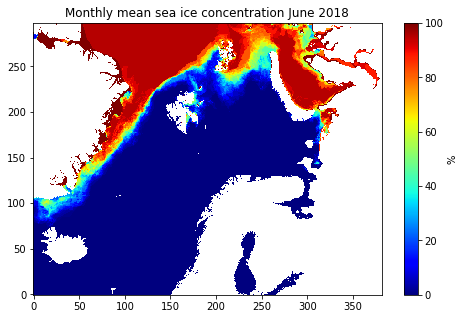

In [34]:
# Sample every 10th data point of the 'sic' variable
dset = Dataset(outfile,'r')
sicmap = dset.variables['sic'][::10,::10]

# Make image with colour map jet (as example)
plt.figure(figsize=(8,5))
plt.imshow(sicmap, origin='lower', cmap='jet') 
cbar = plt.colorbar()
cbar.set_label('%')
plt.title(dset.title)
#plt.xlabel('X')
#plt.ylabel('Y')
image_file = 'tssic-mean.png' # input('Name of plot file (PNG): ')
plt.savefig(image_file, bbox_inches=0)

# Close data file
dset.close()

print('Graphics of mean sea ice concentration is stored in file', image_file)